In [1]:
import numpy as np
import scipy.linalg as la
import fun as f
import networkx as nx
from scipy.integrate import quad
from matplotlib import pyplot as plt

## Test cases:
* Verify the integral is computed correctly by comparing with the quad function form `scipy`
* Compute the sgd between the same graph, result must be zero.
* Evaluate the experiments performed with the WS models with reference models generated for different rewiring probabilities.

In [2]:
W_1 = np.ones((5,5))
D_1 = np.diag(np.sum(W_1,0))
L_1 = D_1 - W_1

In [3]:
eigenvalues_L1, eigenvectors_L1 = la.eig(L_1)
eigenvalues_L1 = eigenvalues_L1.real

In [4]:
W_2 = W_1 + 1
D_2 = np.diag(np.sum(W_2, 0))
L_2 = D_2 - W_2

In [5]:
eigenvalues_L2, eigenvectors_L2 = la.eig(L_2)
eigenvalues_L2 = eigenvalues_L2.real

In [6]:
norm_eigenv1 = np.copy(eigenvectors_L1)
for i in range(len(eigenvectors_L1)):
    dem = (np.max(eigenvectors_L1[:,i]) - np.min(eigenvectors_L1[:,i]))
    num = (eigenvectors_L1[:,i] - np.min(eigenvectors_L1[:,i] ))
    norm_eigenv1[:,i] = num/dem


In [7]:
norm_eigenv2 = np.copy(eigenvectors_L2)
for i in range(len(eigenvectors_L2)):
    dem = (np.max(eigenvectors_L2[:,i]) - np.min(eigenvectors_L2[:,i]))
    num = (eigenvectors_L2[:,i] - np.min(eigenvectors_L2[:,i] ))
    norm_eigenv2[:,i] = num/dem


In [8]:
f.pairwise_spectral_dist(f.sort_eigenv(eigenvalues_L1, eigenvectors_L1),
                         f.sort_eigenv(eigenvalues_L2, eigenvectors_L2))

(0.0, 1.457167719820518e-17)

## Test Hamming Distance

In [9]:
#Generate models to compare:
test_hd = {}
n=10
k=4
rp = np.arange(0,1.1,0.1)
for p in rp:
    test_hd[p] = nx.watts_strogatz_graph(n, k, p,1234)

In [10]:
#Compute Hamming Distance:
matrix_test = np.zeros((len(rp), len(rp)))
for idxi, i  in enumerate(rp):
    for idxj, j in enumerate(rp):
        matrix_test[idxi][idxj] = np.round(np.sum(np.abs(nx.adjacency_matrix(test_hd[i]).todense()
                                                         - nx.adjacency_matrix(test_hd[j]).todense()))/(10 * 9),2
                                          )
        

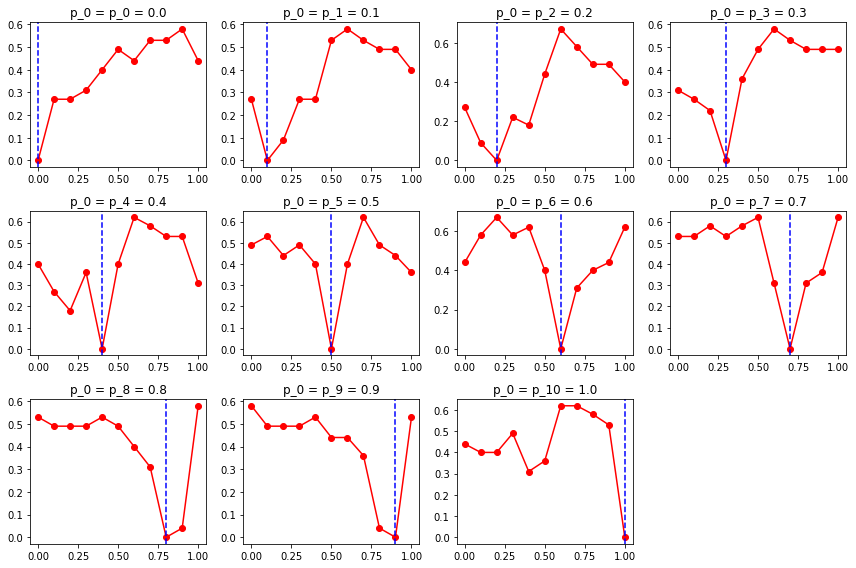

In [12]:
fig = plt.figure(figsize=(12, 8))
for i in range(len(rp)):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    plt.title('p_0 = p_'+str(i) + " = " + str(np.round(rp[i],3)) )
    plt.plot(rp, matrix_test[i], '-o', color = 'red')
    plt.axvline(x = rp[i], color = 'blue', linestyle = '--')
    

In [13]:
## Generate Reference models
test_reference_hd = {}
n=10
k=4
rp = np.arange(0,1.1,0.1)
for p in rp:
    test_reference_hd[p] = nx.watts_strogatz_graph(n, k, p, seed=152345)

In [14]:
#Compute Hamming Distance:
matrix_test = np.zeros((len(rp), len(rp)))
for idxi, i  in enumerate(rp):
    for idxj, j in enumerate(rp):
        matrix_test[idxi][idxj] = np.sum(np.abs(nx.adjacency_matrix(test_reference_hd[i]).todense()
                                                         - nx.adjacency_matrix(test_hd[j]).todense()))/(n*(n-1))
        

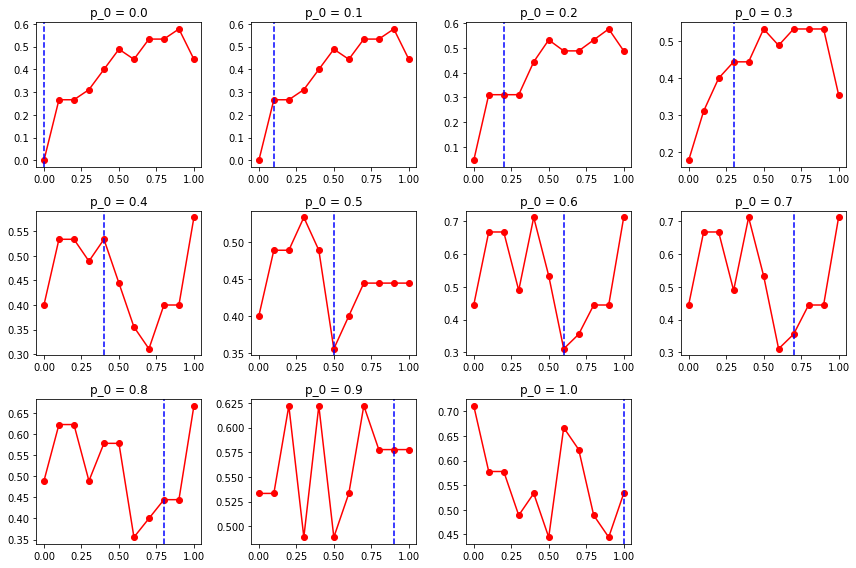

In [15]:
fig = plt.figure(figsize=(12, 8))
for i in range(len(rp)):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    plt.title('p_0 = '+ str(np.round(rp[i],3)) )
    plt.plot(rp, matrix_test[i], '-o', color = 'red')
    plt.axvline(x = rp[i], color = 'blue', linestyle = '--')
    

## Bigger networks

In [16]:
## For bigger networks:
test_hd = {}
n=300
k=10
rp = np.arange(0,1.1,0.1)
for p in rp:
    test_hd[p] = nx.watts_strogatz_graph(n, k, p)

In [17]:
#Compute Hamming Distance:
matrix_test = np.zeros((len(rp), len(rp)))
for idxi, i  in enumerate(rp):
    for idxj, j in enumerate(rp):
        matrix_test[idxi][idxj] = np.round(np.sum(np.abs(nx.adjacency_matrix(test_hd[i]).todense()
                                                         - nx.adjacency_matrix(test_hd[j]).todense()))/(10 * 9),2
                                          )
        

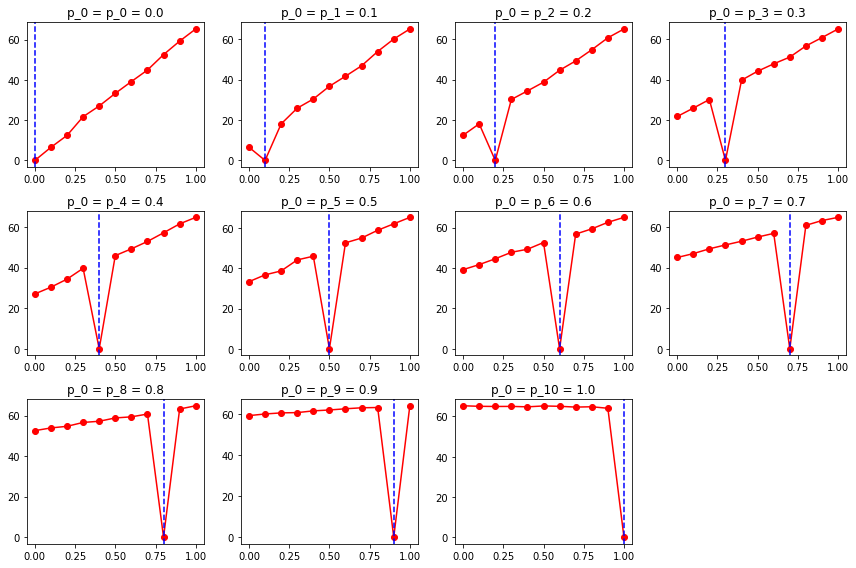

In [18]:
fig = plt.figure(figsize=(12, 8))
for i in range(len(rp)):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    plt.title('p_0 = p_'+ str(i) + " = " + str(np.round(rp[i],3)) )
    plt.plot(rp, matrix_test[i], '-o', color = 'red')
    plt.axvline(x = rp[i], color = 'blue', linestyle = '--')
    

# With reference model:

In [19]:
## Generate Reference models
test_reference_hd = {}
n=300
k=10
rp = np.arange(0,1.1,0.1)
for p in rp:
    test_reference_hd[p] = nx.watts_strogatz_graph(n, k, p, seed=152345)

In [20]:
#[[(list([nx.adjacency_matrix(graph).todense() for graph in test_reference_hd.values()])[i] !=  list([nx.adjacency_matrix(graph).todense() for graph in test_hd.values()])[i]).sum()/(300*299)]for i in range(len(rp))]

In [21]:
#Compute Hamming Distance:
matrix_test = np.zeros((len(rp), len(rp)))
ref_dist = {}
for idxi, i  in enumerate(rp):
    test = []
    for idxj, j in enumerate(rp):
        test.append(np.sum(np.abs(nx.adjacency_matrix(test_reference_hd[i]).todense() - nx.adjacency_matrix(test_hd[j]).todense()))/(n*(n-1)) )
    ref_dist[i] = test
       # matrix_test[idxi][idxj] =np.sum(np.abs(nx.adjacency_matrix(test_reference_hd[i]).todense()
        #                                                 - nx.adjacency_matrix(test_hd[j]).todense()))/(n*(n-1))        

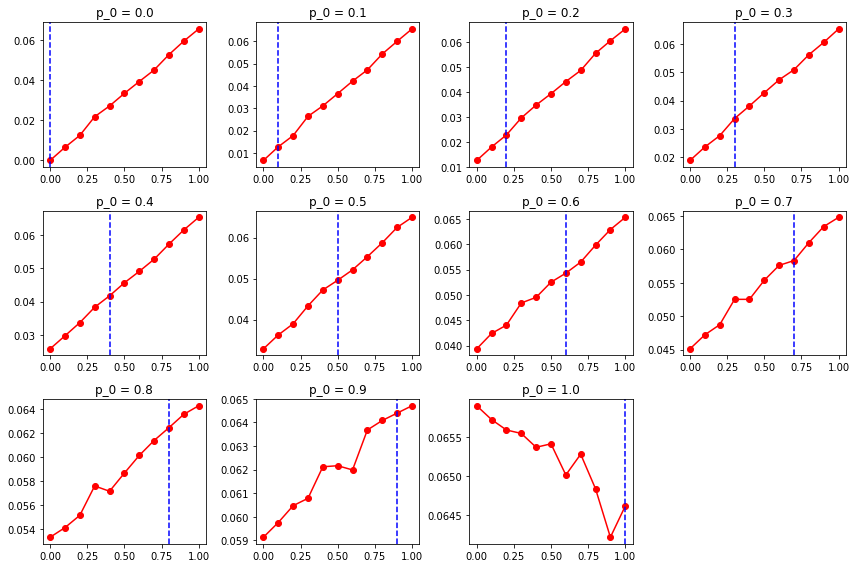

In [22]:
fig = plt.figure(figsize=(12, 8))
for i in range(len(rp)):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    plt.title('p_0 = '+ str(np.round(rp[i],3)) )
    plt.plot(rp, ref_dist[rp[i]], '-o', color = 'red')
    plt.axvline(x = rp[i], color = 'blue', linestyle = '--')
    